In [1]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout

from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
data = pd.read_csv('PGE_SA.csv').fillna(0)
data = data.sort_index(ascending=False)
data.index = range(len(data))
data.head()

,Data,Otwarcie,Zamknięcie,Maks.,Min.,Obrót (mln. zł),Zmiana (%)
0,2010-10-01,17.16,16.98,17.16,16.85,30.36,0.00
1,2010-10-04,16.98,17.05,17.07,16.73,47.29,0.43
2,2010-10-05,16.99,16.82,17.00,16.82,36.29,-1.38
3,2010-10-06,16.87,16.50,16.93,16.50,48.64,-1.88
4,2010-10-07,15.72,15.84,16.05,15.67,271.00,-4.00


## Visualizing train data

<ipython-input-3-48af26f4e858>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates:pd.datetime.strptime(dates, '%Y-%m-%d')


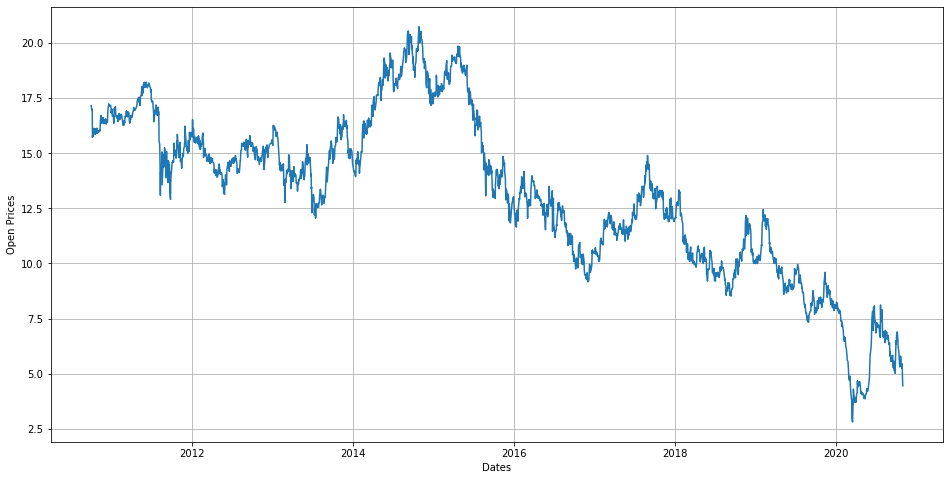

In [3]:
dateparse = lambda dates:pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('PGE_SA.csv', parse_dates=['Data'], index_col='Data', date_parser=dateparse)
data = data.sort_index(ascending=True)
plt.figure(figsize=(16, 8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Otwarcie'])

## Plotting autocorrelation

No handles with labels found to put in legend.


         t-1      t+1
t-1  1.00000  0.83403
t+1  0.83403  1.00000


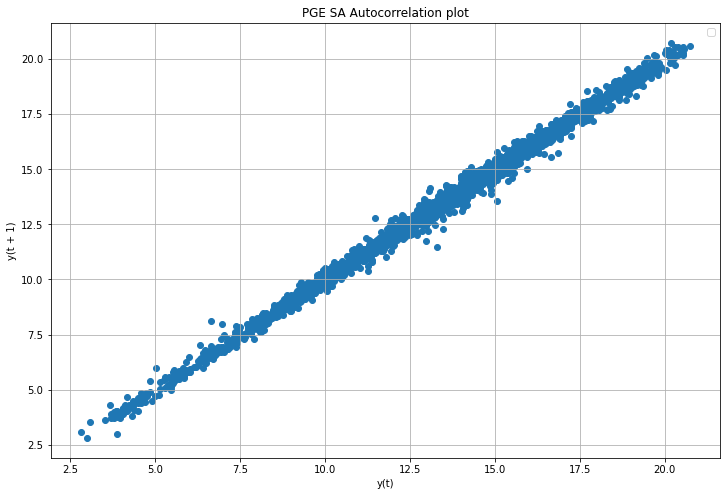

In [4]:
from pandas.plotting import lag_plot
plt.figure(figsize=(12, 8))
lag_plot(data['Otwarcie'], lag=1)
plt.title('PGE SA Autocorrelation plot')
plt.grid(True)
plt.legend();

from pandas import DataFrame
from pandas import concat
values = DataFrame(data['Otwarcie'].values)
dataframe = concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

In [5]:
data.tail()

,Otwarcie,Zamknięcie,Maks.,Min.,Obrót (mln. zł),Zmiana (%)
Data,,,,,,
2020-10-26,5.25,5.42,5.44,5.12,8.92,2.77
2020-10-27,5.45,5.11,5.47,4.97,10.57,-5.76
2020-10-28,5.00,4.73,5.05,4.73,12.75,-7.32
2020-10-29,4.70,4.50,4.74,4.46,15.90,-4.99
2020-10-30,4.45,4.51,4.59,4.26,19.32,0.31


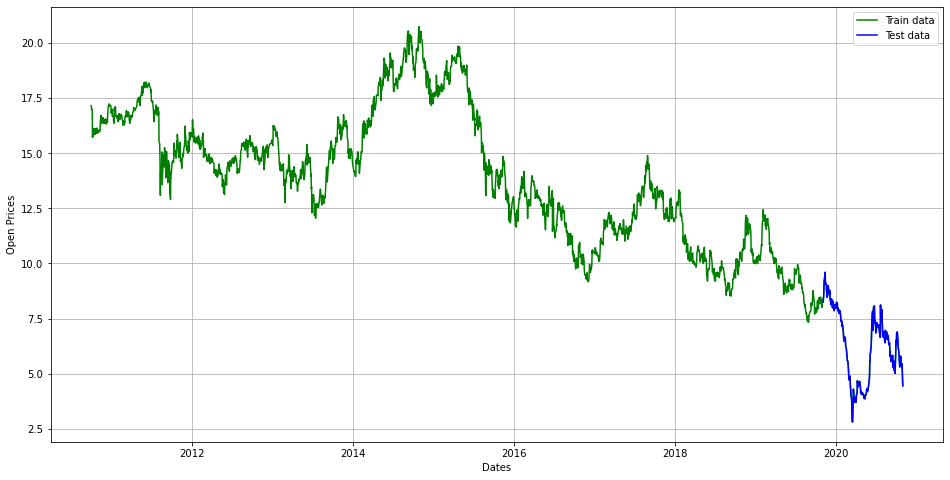

In [6]:
train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):int(len(data))]
plt.figure(figsize=(16, 8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Otwarcie'], 'green', label='Train data')
plt.plot(test_data['Otwarcie'], 'blue', label='Test data')
plt.legend()

## Autoregression model

D:\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)
D:\anaconda3\li

Lag: 26
MSE: 0.06871862403368667
MAE: 0.19038001943639588
RMSE: 0.26214237359436315


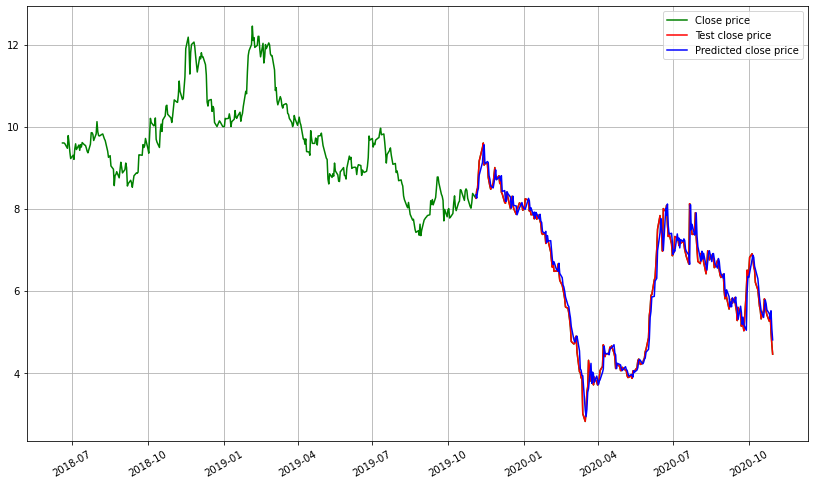

In [7]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

train_ar = train_data['Otwarcie']
test_ar = test_data['Otwarcie']
# train autoregression
model = AR(train_ar)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = train_ar[len(train_ar)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test_ar)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test_ar[t]
    predictions.append(yhat)
    history.append(obs)
    
plt.figure(figsize=(14,8))
print('Lag: %s' % model_fit.k_ar)
plt.plot(data.index[-600:], data['Otwarcie'].tail(600), color='green', label='Close price')
plt.plot(test_data.index, test_data['Otwarcie'], color='red', label='Test close price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted close price')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
mse = mean_squared_error(test_data['Otwarcie'], predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data['Otwarcie'], predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data['Otwarcie'], predictions))
print('RMSE: '+str(rmse))

## ARIMA model

<ipython-input-8-ecafef0f9860>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(data_arima[-1000:], model='multiplicative', freq=30)


<Figure size 1152x576 with 0 Axes>

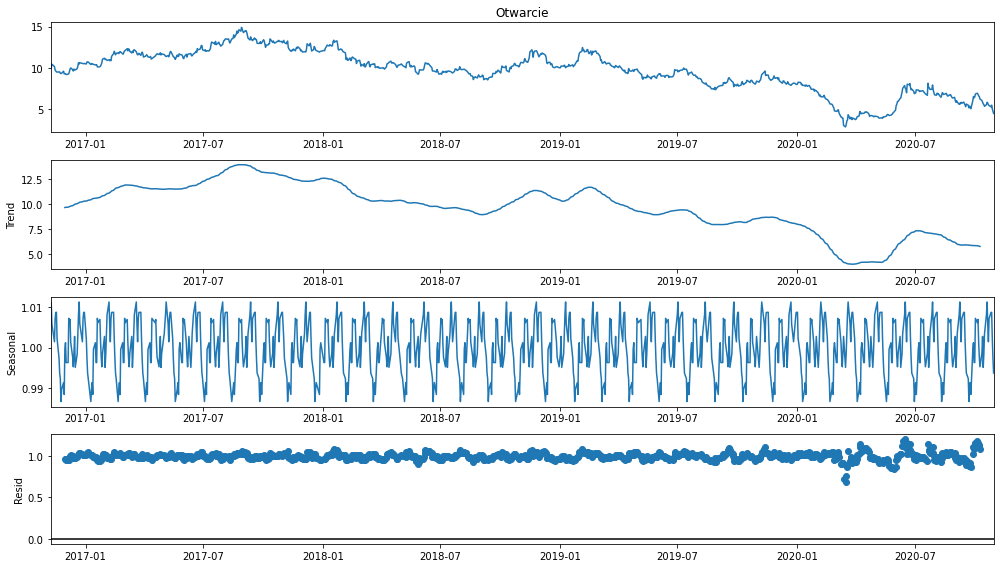

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
data_arima = data['Otwarcie']
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data_arima[-1000:], model='multiplicative', freq=30)
plt.figure(figsize=(16, 8))
fig = result.plot()
plt.show()

In [9]:
train_arima = train_data['Otwarcie']
test_arima = test_data['Otwarcie']

history = [x for x in train_arima]
y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
# report performance
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

MSE: 0.06412513099917402
MAE: 0.17995154308366268
RMSE: 0.25322940389925896


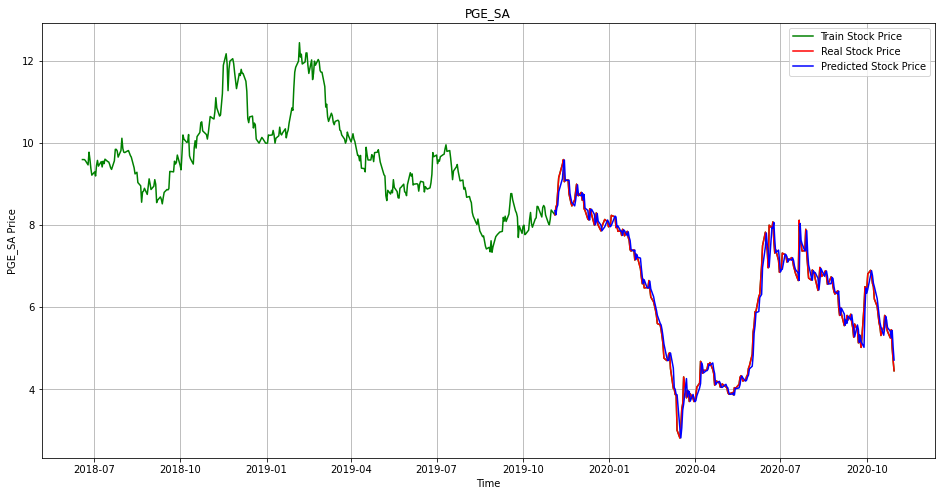

In [10]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Otwarcie'].tail(600), color='green', label='Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('PGE_SA')
plt.xlabel('Time')
plt.ylabel('PGE_SA Price')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
train = train_data.iloc[:, 0:1].values # selecting open prices

## Feature Scaling

In [12]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)

## Now we wil creating a data structure with 30 timesteps and 1 output, i.e. Open Stock Price

In [13]:
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # we take 30 previous prices
    y_train.append(train_scaled[i, 0]) # and 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)

## Reshaping
* Here second argument is (batch_size, time_step, input_dim)
* batch_size is total number of stock price from 2009-12-31 to 2016, i.e. given by X_train.shape[0]
* time_step is total number of previous stock price we want to consider while predictiong present stock price, i.e. given by X_train.shape[1]
* third argument is input_dim-in our case it is 1, i.e. Open price, but it can be more than one. It basically includes all those factors/indicators that can affect present stock price

In [14]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
from numpy.random import seed
seed(2019)

## Building the RNN

In [15]:
model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.20))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 40, batch_size = 32)

Epoch 1/40
71/71 [==============================] - 9s 14ms/step - loss: 0.1039: 0s - loss: 0.10
Epoch 2/40
71/71 [==============================] - 1s 15ms/step - loss: 0.0061
Epoch 3/40
71/71 [==============================] - 1s 15ms/step - loss: 0.0048
Epoch 4/40
71/71 [==============================] - 1s 15ms/step - loss: 0.0054
Epoch 5/40
71/71 [==============================] - 1s 15ms/step - loss: 0.0041
Epoch 6/40
71/71 [==============================] - 1s 15ms/step - loss: 0.0039
Epoch 7/40
71/71 [==============================] - 1s 16ms/step - loss: 0.0040
Epoch 8/40
71/71 [==============================] - 1s 13ms/step - loss: 0.0038
Epoch 9/40
71/71 [==============================] - 1s 13ms/step - loss: 0.0039
Epoch 10/40
71/71 [==============================] - 1s 12ms/step - loss: 0.0037: 0s 
Epoch 11/40
71/71 [==============================] - 1s 12ms/step - loss: 0.0036
Epoch 12/40
71/71 [==============================] - 1s 12ms/step - loss: 0.0033
Epoch 13/40
71/

## Now making the predictions and visualising the results

In [16]:
# this will be used later while comparing and visualization
real_stock_price = test_data.iloc[:, 0:1].values # taking open price

In [17]:
# combine original train and test data vertically
# as previous Open Prices are not present in the test dataset
# e.g. for predicting Open price for first date in the test data, we will need stocl open prices on timesteps previous dates
combine = pd.concat((train_data['Otwarcie'], test_data['Otwarcie']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) -timesteps:].values
test_inputs  = test_inputs.reshape(-1, 1)
test_inputs = scaler.transform(test_inputs)

In [18]:
test_data.shape

(253, 6)

In [19]:
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

## Visualising the results

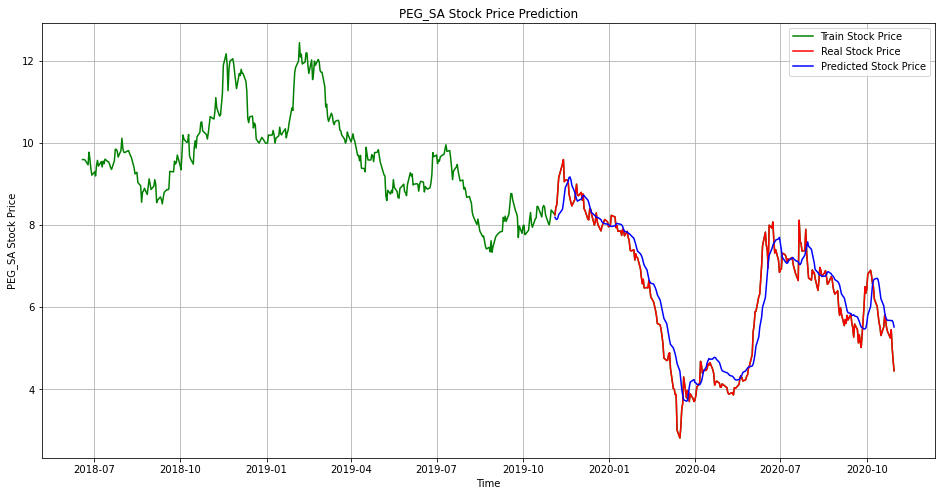

MSE: 0.265248050389871
MAE: 0.4002059116288136
RMSE: 0.5150223785330799


In [21]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Otwarcie'].tail(600), color = 'green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('PEG_SA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('PEG_SA Stock Price')
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))